<a href="https://colab.research.google.com/github/ebrahimpichka/ResNet50-knowledge-distillation/blob/main/ResNet50_knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Load and prepare dataset

In [ ]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 43s 0us/step


In [ ]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [ ]:
X_train = preprocess_image_input(training_images)
X_val = preprocess_image_input(validation_images)

(50000, 32, 32, 3) (10000, 32, 32, 3)


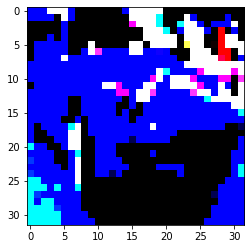

In [ ]:
n_train = X_train.shape[0]
n_test = X_val.shape[0]

print(X_train.shape, X_val.shape)

plt.imshow(X_train[5])
plt.show()

# ResNet50

## ResNet50 model creator func

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

n_classes = len(classes)

def create_model_resnet50():

    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resize = tf.keras.layers.UpSampling2D(size=(4,4))(inputs)
    x = ResNet50(input_shape=(128, 128, 3), include_top=False,weights='imagenet')(resize)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    classification_output = tf.keras.layers.Dense(n_classes, activation="softmax", name="classification")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

## create ResNet50 model instance and fine-tune last layer

In [ ]:
resnet50_model = create_model_resnet50()
for layer in resnet50_model.layers[:-2]:
    layer.trainable = False
resnet50_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 128, 128, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# fine-tuning last layer
BATCH_SIZE = 128
EPOCHS = 4
history = resnet50_model.fit(X_train, training_labels, epochs=EPOCHS, validation_data = (X_val, validation_labels), batch_size=BATCH_SIZE)

Epoch 1/4
391/391 [==============================] - 228s 569ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.8061 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.6830
Epoch 2/4
391/391 [==============================] - 175s 448ms/step - loss: 0.3123 - sparse_categorical_accuracy: 0.8942 - val_loss: 0.6388 - val_sparse_categorical_accuracy: 0.8070
Epoch 3/4
391/391 [==============================] - 177s 454ms/step - loss: 0.2402 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.4498 - val_sparse_categorical_accuracy: 0.8567
Epoch 4/4
391/391 [==============================] - 177s 454ms/step - loss: 0.1590 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.4694 - val_sparse_categorical_accuracy: 0.8562


In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

## visualizing learning curve


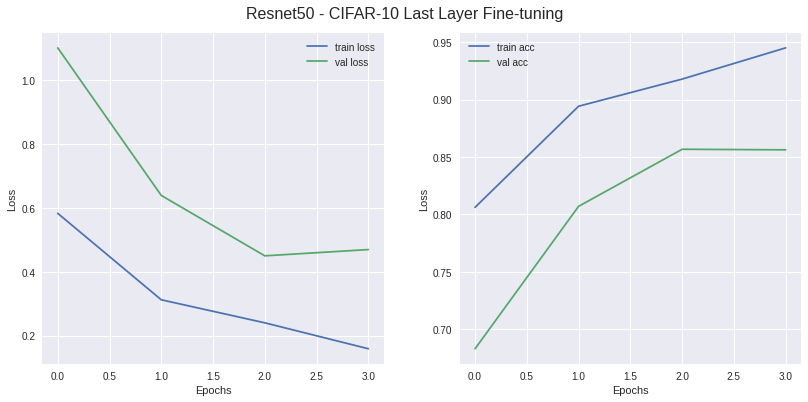

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(list(range(EPOCHS)),history.history['loss'], label='train loss')
plt.plot(list(range(EPOCHS)),history.history['val_loss'], label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(EPOCHS)),history.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(list(range(EPOCHS)),history.history['val_sparse_categorical_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.suptitle("Resnet50 - CIFAR-10 Last Layer Fine-tuning", fontsize=16)
plt.tight_layout(3.5)
plt.savefig('Resnet50-Last Layer Fine-tuning.png');

In [ ]:
resnet50_model.save_weights("ResNet50_LastLyr_Finetuned_CIFAR10_4ep.h5")

# ResNet18 (Distilled from pretrained ResNet50)

In [ ]:
!pip install keras-cv --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 595 kB 15.2 MB/s 


In [ ]:
from keras_cv.models import ResNet18

## ResNet18 model creator func

In [ ]:
def create_model_resnet18(compile=True):

    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resize = tf.keras.layers.UpSampling2D(size=(4,4))(inputs)
    x = ResNet18(include_rescaling=True, include_top=False, input_shape=(128, 128, 3))(resize)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    classification_output = tf.keras.layers.Dense(n_classes, activation="softmax", name="classification")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    if compile:
        model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy',
                    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## create teacher (RN-50 pretrained) and student (RN-18) model instances

In [ ]:
teacher = resnet50_model

# Create the student
student = create_model_resnet18(compile=False)


In [ ]:
student.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 128, 128, 3)      0         
 2D)                                                             
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11186112  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [ ]:
teacher.evaluate(X_val, validation_labels)

313/313 [==============================] - 13s 41ms/step - loss: 0.4694 - sparse_categorical_accuracy: 0.8562


[0.46941474080085754, 0.8561999797821045]

teacher has around 85% acc on test set.

## create, compile, and train distiller instance

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=20,
)

# Distill teacher to student
distill_hist = distiller.fit(X_train, training_labels, validation_data = (X_val, validation_labels), epochs=EPOCHS)


Epoch 1/4


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 141s 86ms/step - sparse_categorical_accuracy: 0.4813 - student_loss: 1.4286 - distillation_loss: 0.0288 - val_sparse_categorical_accuracy: 0.5365 - val_student_loss: 1.3702
Epoch 2/4
1563/1563 [==============================] - 133s 85ms/step - sparse_categorical_accuracy: 0.6603 - student_loss: 0.9680 - distillation_loss: 0.0197 - val_sparse_categorical_accuracy: 0.6994 - val_student_loss: 0.8888
Epoch 3/4
1563/1563 [==============================] - 134s 85ms/step - sparse_categorical_accuracy: 0.7454 - student_loss: 0.7363 - distillation_loss: 0.0150 - val_sparse_categorical_accuracy: 0.7361 - val_student_loss: 1.2820
Epoch 4/4
1563/1563 [==============================] - 134s 85ms/step - sparse_categorical_accuracy: 0.8001 - student_loss: 0.5863 - distillation_loss: 0.0119 - val_sparse_categorical_accuracy: 0.7835 - val_student_loss: 0.5829


In [ ]:
# Evaluate student on test dataset
distiller.evaluate(X_val, validation_labels)

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.7835 - student_loss: 0.6361


[0.7835000157356262, 0.5829317569732666]

## visualizing learning curve

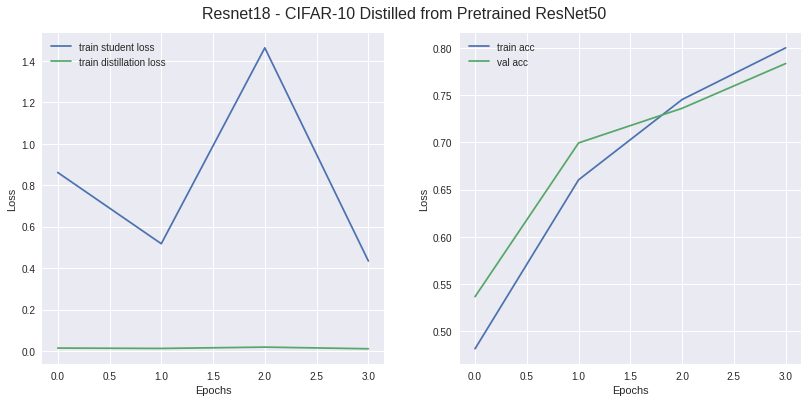

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(list(range(EPOCHS)),distill_hist.history['student_loss'], label='train student loss')
plt.plot(list(range(EPOCHS)),distill_hist.history['distillation_loss'], label='train distillation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(EPOCHS)),distill_hist.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(list(range(EPOCHS)),distill_hist.history['val_sparse_categorical_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.suptitle("Resnet18 - CIFAR-10 Distilled from Pretrained ResNet50", fontsize=16)
plt.tight_layout(3.5)
plt.savefig('Resnet18-distiled from resnet50.png');

In [ ]:
trained_student = distiller.student
trained_student.save_weights("ResNet18_Distilled_FromResNet50_4ep.h5")

# ResNet18 (trained from scratch w/o distillating)

## create and train RN-18 model instance

In [ ]:

# Clone student
student_scratch = tf.keras.models.clone_model(student)

# Train student from scratch
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
resnet18_hist = student_scratch.fit(X_train, training_labels, validation_data = (X_val, validation_labels), epochs=4)

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 123s 47ms/step - loss: 1.4688 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.1946 - val_sparse_categorical_accuracy: 0.5749
Epoch 2/4
1563/1563 [==============================] - 74s 47ms/step - loss: 1.0059 - sparse_categorical_accuracy: 0.6441 - val_loss: 1.0750 - val_sparse_categorical_accuracy: 0.6387
Epoch 3/4
1563/1563 [==============================] - 75s 48ms/step - loss: 0.7714 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.7572 - val_sparse_categorical_accuracy: 0.7400
Epoch 4/4
1563/1563 [==============================] - 75s 48ms/step - loss: 0.6091 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.6943 - val_sparse_categorical_accuracy: 0.7661


In [ ]:
student_scratch.evaluate(X_val, validation_labels)

313/313 [==============================] - 4s 14ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.7661


[0.6943344473838806, 0.7660999894142151]

## visualizing learning curve

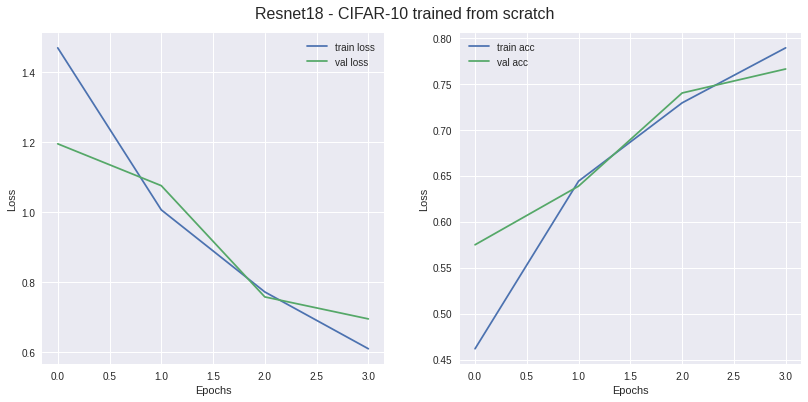

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(list(range(EPOCHS)),resnet18_hist.history['loss'], label='train loss')
plt.plot(list(range(EPOCHS)),resnet18_hist.history['val_loss'], label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(EPOCHS)),resnet18_hist.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(list(range(EPOCHS)),resnet18_hist.history['val_sparse_categorical_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.suptitle("Resnet18 - CIFAR-10 trained from scratch", fontsize=16)
plt.tight_layout(3.5);

# ResNet50 (fine-tuning the whole network)

This time, instead of fine-tunung the last layer. we fine-tune the whole network.

## create and fine-tune RN-50 model instance

In [ ]:
# Train ResNet50 from scratch
resnet50_ft_all_layers = create_model_resnet50()

for layer in resnet50_ft_all_layers.layers:
    layer.trainable = True

# Train and evaluate student trained from scratch.
resnet50_all_hist = resnet50_ft_all_layers.fit(X_train, training_labels, validation_data = (X_val, validation_labels), epochs=4)

Epoch 1/4
1563/1563 [==============================] - 221s 138ms/step - loss: 0.8238 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7609
Epoch 2/4
1563/1563 [==============================] - 214s 137ms/step - loss: 0.4937 - sparse_categorical_accuracy: 0.8329 - val_loss: 0.6296 - val_sparse_categorical_accuracy: 0.7948
Epoch 3/4
1563/1563 [==============================] - 223s 143ms/step - loss: 0.3733 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.5968 - val_sparse_categorical_accuracy: 0.8030
Epoch 4/4
1563/1563 [==============================] - 215s 138ms/step - loss: 0.2931 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.4926 - val_sparse_categorical_accuracy: 0.8394


In [ ]:
resnet50_ft_all_layers.evaluate(X_val, validation_labels)

313/313 [==============================] - 12s 39ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.8394


[0.4925635755062103, 0.8393999934196472]

## visualizing learning curve

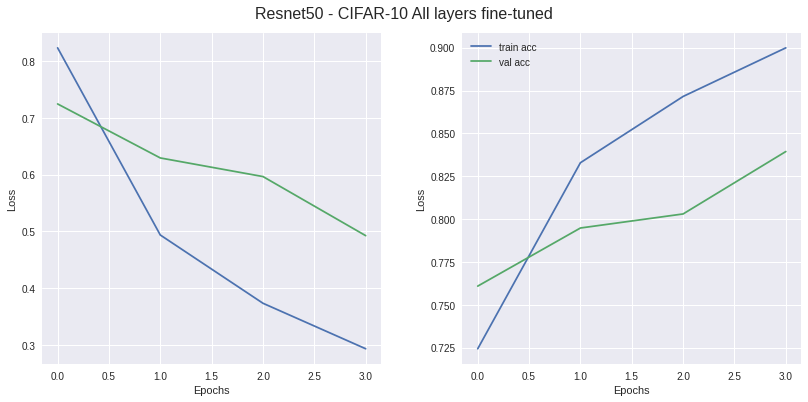

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(list(range(EPOCHS)),resnet50_all_hist.history['loss'], label='train loss')
plt.plot(list(range(EPOCHS)),resnet50_all_hist.history['val_loss'], label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(list(range(EPOCHS)),resnet50_all_hist.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(list(range(EPOCHS)),resnet50_all_hist.history['val_sparse_categorical_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.suptitle("Resnet50 - CIFAR-10 All layers fine-tuned", fontsize=16)
plt.tight_layout(3.5)
plt.savefig('Resnet50-All layers fine-tuned.png');

In [ ]:
resnet50_ft_all_layers.save_weights("ResNet50_CIFAR10_all_lyrs_finetuned_4ep.h5")

# comparing the results 

In [ ]:
RN50_linearFT_res = resnet50_model.evaluate(X_val, validation_labels)
RN18_distilledRN50_res = distiller.evaluate(X_val, validation_labels)
RN18_scratch_res = student_scratch.evaluate(X_val, validation_labels)
RN50_fullFT_res = resnet50_ft_all_layers.evaluate(X_val, validation_labels)


313/313 [==============================] - 12s 37ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.8394


In [ ]:

rep = pd.DataFrame(
    {
        "RN50 linearFT":RN50_linearFT_res ,
        "RN18 distilledRN50":reversed(RN18_distilledRN50_res) ,
        "RN18 scratch":RN18_scratch_res ,
        "RN50 fullFT":RN50_fullFT_res ,
    },
    index=["val_loss", "val_acc"]
).T

rep

,val_loss,val_acc
RN50 linearFT,0.469415,0.8562
RN18 distilledRN50,0.582932,0.7835
RN18 scratch,0.694334,0.7661
RN50 fullFT,0.492564,0.8394


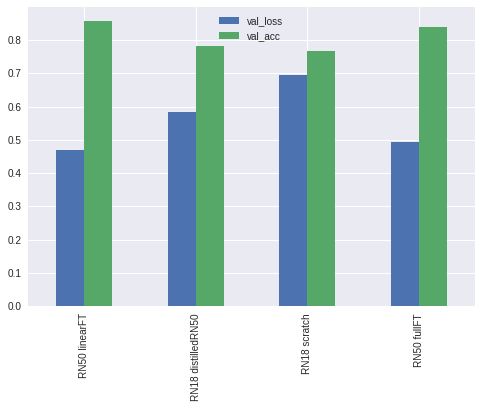

In [ ]:
rep.plot(kind='bar')